In [344]:
# required imports
from vivarium.plots.simulation_output import _save_fig_to_dir as save_fig_to_dir
import ast
import cobra
from cobra import io
import os
import sys
%matplotlib inline
import matplotlib.pyplot as plt
from vivarium.plots.topology import plot_topology

In [345]:
# Define the path to the SBML model file
model_path = "../vivarium_microbiome/data/Alteromonas_Model.xml"

In [346]:
# Load the model
model = io.read_sbml_model(model_path)

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.


In [347]:
# 1. Number of all reactions
total_reactions = len(model.reactions)
print(f"Total number of reactions: {total_reactions}")

Total number of reactions: 881


In [348]:
# 2. Number of exchange fluxes
exchange_reactions = [reaction for reaction in model.reactions if reaction.id.startswith('EX_')]
num_exchange_fluxes = len(exchange_reactions)
print(f"Number of exchange fluxes: {num_exchange_fluxes}")

Number of exchange fluxes: 62


In [349]:
# Extract and print human-friendly information for exchange reactions
exchange_reactions = [reaction for reaction in model.reactions if reaction.id.startswith('EX_')]
print("Human-friendly exchange reactions information:")
for reaction in exchange_reactions:
    # Format the bounds in a readable way
    bounds = f"[{reaction.lower_bound}, {reaction.upper_bound}]"
    
    # Print the details
    #print(f"ID: {reaction.id}, Name: {reaction.name}, Bounds: {bounds}")

Human-friendly exchange reactions information:


In [350]:
# Optional: Specify the reaction ID for which you want to find the name
reaction_id_to_find = "EX_cpd00033_e0"

# Find the reaction by its ID and print its name
for reaction in model.reactions:
    if reaction.id == reaction_id_to_find:
        print(f"The name of the reaction with ID '{reaction_id_to_find}' is: '{reaction.name}'")
        break
else:
    print(f"No reaction found with the ID '{reaction_id_to_find}'")

The name of the reaction with ID 'EX_cpd00033_e0' is: 'Exchange for Glycine_e0'


In [351]:
# Optional: Dictionary for exchange fluxes: ID as key, Name as value
name_exchange_fluxes_dict = {reaction.id: reaction.name for reaction in model.reactions if reaction.id.startswith('EX_')}

#print(name_exchange_fluxes_dict)

In [352]:
# Dictionary for exchange fluxes: ID as key, Bounds as value
bound_exchange_fluxes_dict = {reaction.id: f"[{reaction.lower_bound}, {reaction.upper_bound}]" 
                        for reaction in model.reactions if reaction.id.startswith('EX_')}

# Adding an empty key and value
new_key = "None"  # This is an example key. 
bound_exchange_fluxes_dict[new_key] = "None"

# Print the dictionary
#print(bound_exchange_fluxes_dict)

In [353]:
# Import the FBA class and the main function from the Fba_process.py file
sys.path.append('../vivarium_microbiome/processes/Altrmns/')
from Fba import FBA, main

In [354]:
# Function to process model with setting the bound to a given flux_id as zero
def process_model(model_path, flux_id, flux_name):
    if flux_id == "None":
        output, processes, topology = main(model_path)
    else:
        reaction_id = flux_id  # Assuming the key itself is the reaction ID
        bounds = [0, 0]  # Set bounds to zero
        output, processes, topology = main(model_path, reaction_id, bounds)
        print(f"Set {flux_name} as zero. Flux ID: {flux_id}")

    return output

In [355]:
# Function to extract flux data from output
def extract_flux_data(output):
    if isinstance(output, str):
        output = ast.literal_eval(output)
    flux_data = output[1]['fluxes_values']
    return flux_data

In [356]:
# Function to sort and print flux details
def sort_and_print_fluxes(flux_data, flux_type):
    sorted_fluxes = sorted(flux_data.items(), key=lambda item: item[1])
    num_fluxes = len(sorted_fluxes)
    print(f"Number of {flux_type} Fluxes: {num_fluxes}")

    print(f"\n{flux_type} Fluxes:")
    for key, value in sorted_fluxes:
        print(f'{key}: {value}')

In [357]:
def ex_bar_chart(flux_data, flux_name, ex_output_folder, 
                 bar_colors, objective_flux, objective_flux_label, is_in_original_uptake_list):

    sorted_fluxes = sorted(flux_data.items(), key=lambda item: item[0])
    keys, values = zip(*sorted_fluxes)

    plt.figure(figsize=(12, 6))

    # Plot the regular flux bars
    plt.bar(keys, values, color=bar_colors)

    # Add a white (or transparent) bar for spacing
    plt.bar(len(keys), 0, color='white', width=0.5)

    # Add the objective flux bar separately at the end, in red
    plt.bar(len(keys) + 1, objective_flux, color='red', width=0.5)

    plt.xlabel('Exchange Fluxes')
    plt.ylabel('Flux Value')
    plt.title(f'Exchange Fluxes when {flux_name} is zero')
    plt.xticks(list(range(len(keys) + 2)), list(keys) + ['', objective_flux_label], rotation=90)

    plt.tight_layout()
    uptake_prefix = "up_" if is_in_original_uptake_list else ""
    file_name = f"{uptake_prefix}Ex_{flux_name}_zero_with_objective.png"

    file_path = os.path.join(ex_output_folder, file_name)
    plt.savefig(file_path)
    plt.close()


In [358]:
# def ex_bar_chart(ax, flux_data, flux_name, ex_output_folder, bar_colors, objective_flux, objective_flux_label, is_in_original_uptake_list):
#     sorted_fluxes = sorted(flux_data.items(), key=lambda item: item[0])
#     keys, values = zip(*sorted_fluxes)

#     # Plot the regular flux bars on the provided axes
#     ax.bar(keys, values, color=bar_colors)

#     # Add a white (or transparent) bar for spacing
#     ax.bar(len(keys), 0, color='white', width=0.5)

#     # Add the objective flux bar separately at the end, in red
#     ax.bar(len(keys) + 1, objective_flux, color='red', width=0.5)

#     ax.set_xlabel('Exchange Fluxes')
#     ax.set_ylabel('Flux Value')
#     ax.set_title(f'Exchange Fluxes when {flux_name} is zero')
#     ax.set_xticks(list(range(len(keys) + 2)))
#     ax.set_xticklabels(list(keys) + ['', objective_flux_label], rotation=90)


In [359]:
def calculate_flux_changes(current_flux_dict, original_flux_dict):
    difer_flux_dict = {}
    for flux_id, current_flux in current_flux_dict.items():
        original_flux = original_flux_dict.get(flux_id, 0)
        if original_flux != 0:
            change = abs(current_flux - original_flux) / abs(original_flux)
            difer_flux_dict[flux_id] = change
    return difer_flux_dict

In [360]:
def plot_top_flux_changes(difer_flux_dict, top_n=20):
    # Sort and get the top N changes
    sorted_changes = sorted(difer_flux_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]
    
    # Extract IDs and values for plotting
    flux_ids, changes = zip(*sorted_changes)

    plt.figure(figsize=(10, 6))
    plt.bar(flux_ids, changes, color='brown')
    plt.xlabel('Flux ID')
    plt.ylabel('Normalized Flux Change')
    plt.title(f'Top {top_n} Flux Changes')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [361]:
# def plot_top_flux_changes(ax, difer_flux_dict, top_n=20):
#     # Sort and get the top N changes
#     sorted_changes = sorted(difer_flux_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]
    
#     # Extract IDs and values for plotting
#     flux_ids, changes = zip(*sorted_changes)

#     # Plot the bar chart on the provided axes
#     ax.bar(flux_ids, changes, color='brown')
#     ax.set_xlabel('Flux ID')
#     ax.set_ylabel('Normalized Flux Change')
#     ax.set_title(f'Top {top_n} Flux Changes')
#     ax.set_xticks(range(len(flux_ids)))
#     ax.set_xticklabels(flux_ids, rotation=45)


In [362]:
def main_loop(model_path, bound_exchange_fluxes_dict, name_exchange_fluxes_dict, ex_output_folder):
    # Initialize the dictionary and list to store the original flux data
    original_flux_dict = {}
    all_flux_changes = {}
    original_uptake_list = []

    # First run with flux_id == "None" to populate original_uptake_list
    output = process_model(model_path, "None", "No Reaction")
    flux_data = extract_flux_data(output)
    original_flux_dict = flux_data
    uptake_fluxes = {key: value for key, value in flux_data.items() if key.startswith('EX_') and value < 0}
    original_uptake_list = list(uptake_fluxes.keys())
    
    # Create a subplot with 1 row and 2 columns for each iteration
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6))

    # Now iterate over the other flux IDs
    for flux_id, _ in bound_exchange_fluxes_dict.items():
        if flux_id == "None":
            continue  # Skip the None case as it's already handled

        flux_name = name_exchange_fluxes_dict.get(flux_id, "No Reaction")
        output = process_model(model_path, flux_id, flux_name)
        flux_data = extract_flux_data(output)
        
        
        # Calculate and store the flux changes
        difer_flux_dict = calculate_flux_changes(flux_data, original_flux_dict)
        for key, value in difer_flux_dict.items():
            if key in all_flux_changes:
                all_flux_changes[key] = max(all_flux_changes[key], value)
            else:
                all_flux_changes[key] = value

        # Check if the current flux_id is in original_uptake_list
        is_in_original_uptake_list = flux_id in original_uptake_list

        # Extract exchange, uptake, and secretion fluxes
        exchange_fluxes = {key: value for key, value in flux_data.items() if key.startswith('EX_')}
        uptake_fluxes = {key: value for key, value in exchange_fluxes.items() if value < 0}
        secretion_fluxes = {key: value for key, value in exchange_fluxes.items() if value > 0}
        
        
        # Sort and print fluxes
        sort_and_print_fluxes(uptake_fluxes, "Uptake")
        sort_and_print_fluxes(secretion_fluxes, "Secretion")

        # If output is a string, convert it to a dictionary
        if isinstance(output, str):
            output = ast.literal_eval(output)
        objective_flux = output[1]['objective_flux_value']
        print(f"Objective flux for when eliminate '{flux_id}' ({flux_name}): {objective_flux}")

        bar_colors = ['orange' if objective_flux <= 0 else 'blue' for _ in flux_data]
        
        # Call the bar chart function with the necessary parameters
        ex_bar_chart(ax1, exchange_fluxes, flux_name, ex_output_folder, bar_colors, objective_flux, "Objective Flux", is_in_original_uptake_list)

        # Plot the top 20 flux changes
        plot_top_flux_changes(ax2, all_flux_changes)
        
        # Call the bar chart function with the necessary parameters
        ex_bar_chart(ax1, exchange_fluxes, flux_name, ex_output_folder, bar_colors, objective_flux, "Objective Flux", is_in_original_uptake_list)

        
        # After completing the loop, plot the top 20 flux changes
        fig, ax = plt.subplots()
        plot_top_flux_changes(ax, all_flux_changes)
        
            # Save the entire figure after completing the loop
        plt.tight_layout()
        plt.savefig(os.path.join(ex_output_folder, file_name))
        plt.close()
        
#         # After plotting the exchange fluxes and top flux changes for the current flux_id
#         plt.tight_layout()

#         # Determine the file name based on whether the current flux_id is in the original uptake list
#         uptake_prefix = "up_" if is_in_original_uptake_list else ""
#         file_name = f"{uptake_prefix}Ex_{flux_name}_zero_with_objective.png"

#         # Save the figure
#         file_path = os.path.join(ex_output_folder, file_name)
#         plt.savefig(file_path)
#         plt.close()


        
        
        




# Specify the ex_output folder
ex_output_folder = "/Users/amin/Desktop/Microbiome/vivarium_microbiome/output/ex"

# Ensure the ex_output folder exists
os.makedirs(ex_output_folder, exist_ok=True)


ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 6f7f1736-9af2-11ee-a531-ba21c95c07d9
Created: 12/14/2023 at 21:34:13
Completed in 0.067320 seconds


ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 7014c83a-9af2-11ee-a531-ba21c95c07d9
Created: 12/14/2023 at 21:34:14
Completed in 0.042034 seconds
Set Exchange for Cu2+_e0 as zero. Flux ID: EX_cpd00058_e0
Number of Uptake Fluxes: 4

Uptake Fluxes:
EX_cpd00033_e0: -1.4761506276150624
EX_cpd00027_e0: -0.527196652719665
EX_cpd00054_e0: -0.15815899581589965
EX_cpd00067_e0: -0.10543933054393466
Number of Secretion Fluxes: 4

Secretion Fluxes:
EX_cpd00075_e0: 0.15815899581589962
EX_cpd00001_e0: 0.4744769874476987
EX_cpd00047_e0: 0.6853556485355647
EX_cpd00161_e0: 1.4761506276150627
Objective flux for when eliminate 'EX_cpd00058_e0' (Exchange for Cu2+_e0): 0.0


TypeError: ex_bar_chart() takes 7 positional arguments but 8 were given

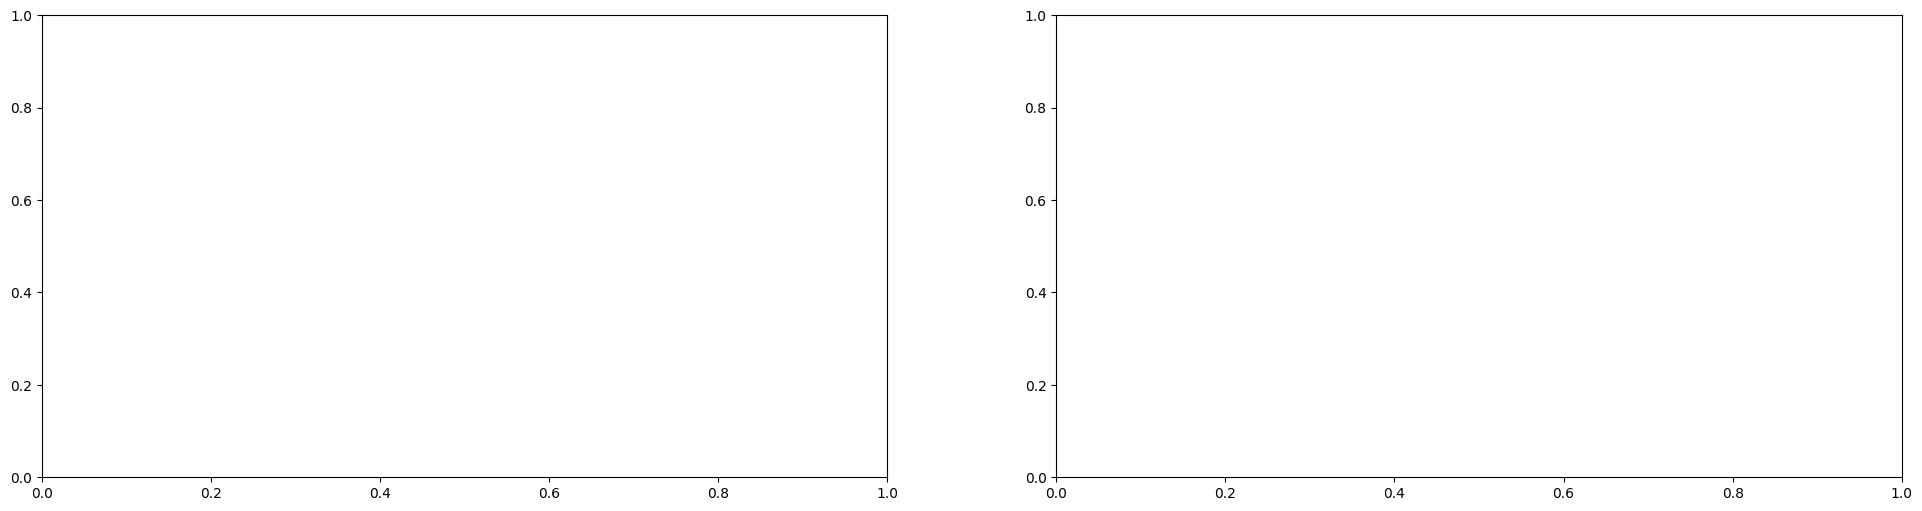

In [363]:
# Call the main loop
main_loop(model_path, bound_exchange_fluxes_dict, name_exchange_fluxes_dict, ex_output_folder)

## Model Topology. 
#### The model compute the FBA and provide the optimized Fluxes, the Objective flux and the reactions. 

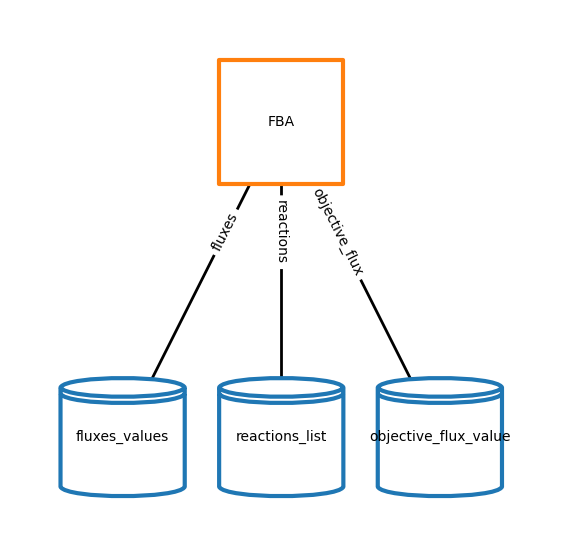

In [29]:
composite = {'processes' : processes , 'topology' : topology , 'steps' : {}, 'flow' : {}}
config ={'font_size' : 10}
fig_topology = plot_topology(composite, config)
